In [49]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score


INPUT_FILE_NAME = 'cases_brandenburg-preprocessed-gesetzgebung-2006-2020_processed_with_context.csv'
#INPUT_FILE_NAME = 'cases_berlin-preprocessed-gesetzgebung-2006-2020_with_context.csv'
INPUT_FILE_NAME_COMPARISON = 'cases_baden-württemberg-preprocessed-gesetzgebung-gesetz-2006-2020_processed_with_context.csv'
'''
#INPUT_FILE_NAME = 'cases_brandenburg-preprocessed-gesetzgebung-2006-2020_processed_with_context_passed_bills.csv'
INPUT_FILE_NAME = 'cases_berlin-preprocessed-gesetzgebung-2006-2020_with_context_passed_bills.csv'
INPUT_FILE_NAME_COMPARISON = 'cases_baden-württemberg-preprocessed-gesetzgebung-gesetz-2006-2020_processed_with_context_passed_bills.csv'
'''

bundesland = "brandenburg"
#bundesland = "berlin_withDelay"


In [50]:
DATA_TYPES = {}

df = pd.read_csv(INPUT_FILE_NAME, dtype=DATA_TYPES)
print('Read', len(df), 'rows from', INPUT_FILE_NAME)

df = df.dropna(axis=1, how='all')  # drop all completely empty columns

#df.info(verbose=True)

Read 718 rows from cases_brandenburg-preprocessed-gesetzgebung-2006-2020_processed_with_context.csv


In [51]:
df_baWue = pd.read_csv(INPUT_FILE_NAME_COMPARISON)

#check for distribution of processes with passed vs not passed bills
#print("Distribution of processes with passed vs not passed bills")
#print(df["is_passed_bill"].value_counts())
#print(df_baWue["is_passed_bill"].value_counts())

'''
df = df[df["is_passed_bill"] == True]
df_baWue = df_baWue[df_baWue["is_passed_bill"] == True]
'''

bawue_average_cycle_time = df_baWue["duration"].mean()
bawue_average_cycle_time_upper_bound = bawue_average_cycle_time + 0.1*bawue_average_cycle_time
bawue_average_cycle_time_lower_bound = bawue_average_cycle_time - 0.1*bawue_average_cycle_time

outcome_function = lambda row: row['duration'] > bawue_average_cycle_time_upper_bound

In [52]:
# split into data and target
target = df.apply(outcome_function, axis=1)
data = df

In [53]:
# remove columns with object type
columns_type_object = data.select_dtypes(include=['object']).columns

print('Columns with object type:', columns_type_object)

data = data.drop(columns=columns_type_object)

# Replace all NaN values with 0
data = data.fillna(0)



Columns with object type: Index(['start_time', 'case:DokTypLFirstDoc', 'case:VSysL',
       'case:VorgangsDeskriptoren', 'case:author_first_activity'],
      dtype='object')


In [54]:
# Use attribute names or regular expressions to hide
HIDE = [
    
    # hide what we want to explain
    'duration',
    r'.*cycle.*',
    
    # hide meaningless columns
    'case_id',
    r'.*none.*',
    r'.*nan.*',
    

        
    # temporal columns
    'start_time_rel',
    'start_time', 
    r'.*start.*', 
    r'.*delay.*',   # comment this for including delay
    
    #r'.*Gesetz.*', # uncomment this when including delay

    # experiments
    #r'.*count.*',

    #"is_passed_bill",
    
    #r'.*:[0-9].*',

    ]

for pattern in HIDE:
    for col in data.columns:
        if re.fullmatch(pattern, col):
            # print('Dropping {} on pattern "{}".'.format(col, pattern))
            data = data.drop(columns=[col])

In [55]:
X = data.to_numpy()
target = target.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.33, random_state=42)

print('Train data:', len(x_train))
print('Test data:', len(x_test))

Train data: 481
Test data: 237


In [56]:
def createConfusionMatrix(y_test_arg, y_pred_arg, nameForSaving):
    
    print(classification_report(y_test_arg, y_pred_arg))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test_arg, y_pred_arg).ravel()

    # Reorder the confusion matrix so positive-positive (tp) is in the upper left
    cm = np.array([[tp, fn],
                   [fp, tn]])

    # Define the class labels
    class_names = ["Positive", "Negative"] 

    # Create the plot with smaller figure size for papers
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Set fixed colormap limits to ensure consistent colors across different matrices
    # You can adjust these values based on your expected range of values
    vmin = 0
    vmax = 100  # Use either the max value or 100, whichever is greater
    
    # Apply the fixed color range to matshow
    cax = ax.matshow(cm, cmap='Blues', vmin=vmin, vmax=vmax)
    
    # Make the colorbar smaller and with larger font
    cbar = fig.colorbar(cax, shrink=0.8)
    cbar.ax.tick_params(labelsize=14)

    # Set axis ticks and labels with larger font
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=14)
    ax.set_yticklabels(class_names, fontsize=14)

    # Set title and y-axis label with larger font
    plt.ylabel('True Labels', fontsize=16)
    
    # Add "Predicted Labels" on top instead of bottom
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top') 

    # Annotate cells with counts using larger font
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center', color='black', fontsize=16, weight='bold')

    # Adjust layout and spacing
    plt.tight_layout()
    
    # Additional spacing adjustments to prevent label cutoff
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    # Save figure with high resolution
    plt.savefig(nameForSaving, dpi=300, bbox_inches='tight')
    plt.show()
    

    
def baselinePredictor(y_train, x_test, y_test):
    countTrue = np.sum(y_train)
    percentageTrue = countTrue / len(y_train)
    # Generate random predictions for x_test based on the proportion of True
    random_predictions = np.random.choice([True, False], size=len(x_test), p=[percentageTrue, 1 - percentageTrue])
    print("Baseline results:\n")
    createConfusionMatrix(y_test, random_predictions, "baselinePredictor" + bundesland + ".png")
    print("\n")
    
    

Baseline results:

              precision    recall  f1-score   support

       False       0.40      0.44      0.42        91
        True       0.63      0.59      0.61       146

    accuracy                           0.53       237
   macro avg       0.51      0.51      0.51       237
weighted avg       0.54      0.53      0.54       237



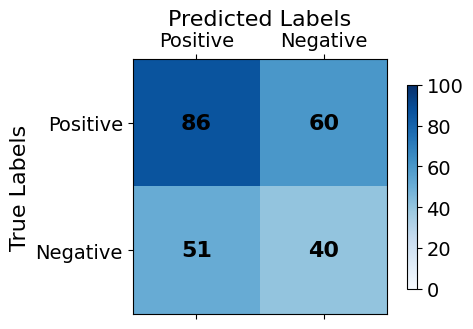

In [57]:
baselinePredictor(y_train, x_test, y_test)

pipe score: 0.8481012658227848
              precision    recall  f1-score   support

       False       0.80      0.81      0.80        91
        True       0.88      0.87      0.88       146

    accuracy                           0.85       237
   macro avg       0.84      0.84      0.84       237
weighted avg       0.85      0.85      0.85       237



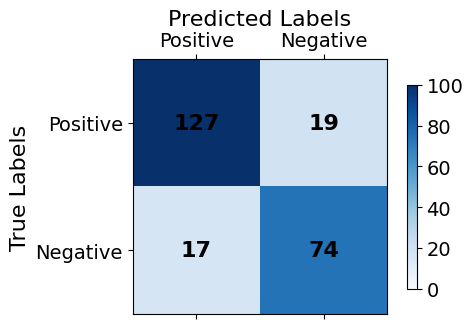


Features and their coefficient from the logistic regressor (normal pipe):

Sitzung.count: 1.7142848913647464
Bekanntmachung.count: 1.0996280307033037
1. Lesung.count: 0.885352119455675
event_count: 0.8170350707736558
2. Lesung.count: 0.7870122062410528
Lesung / Fortsetzung.count: 0.688837459706371
case:author_first_activity_landesregierung: 0.6553763360497242
3. Lesung.count: -0.629803162209122
case:squire: -0.6182595605803957
Änderungsantrag.count: -0.5846804492689643
Beschlussempfehlung und Bericht.count: 0.5135579612104285
case:yearly_frequency: -0.5017465418172232
case:pdf_word_count: 0.4960041925526925
Berichtigung.count: 0.4435110872598397
case:yearly_arrival_rate: 0.43392118107516703
case:yearly_variants: 0.432465906978761
case:author_first_activity_präsidium des landtages: 0.3723916008552359
case:author_first_activity_fritsch, gunter (präsident des landtages brandenburg): -0.36920734571757313
case:af_score: 0.36045876953628464
case:author_first_activity_fraktion bündnis 90/die

In [58]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, fit_intercept=True, random_state=42))
pipe.fit(x_train, y_train)
print("pipe score:", pipe.score(x_test, y_test))
y_pred = pipe.predict(x_test)
createConfusionMatrix(y_test, y_pred, "logisticRegression" + bundesland + ".png")

# Access the final estimator
regressor_normal = pipe.steps[-1][1]

# get names of features that were selected
print("\nFeatures and their coefficient from the logistic regressor (normal pipe):\n")

# Get the coefficients and their corresponding feature names
coefficients_normal = regressor_normal.coef_[0]
features_normal = data.columns

# Combine them into a list of tuples
feature_coefficients_normal = list(zip(features_normal, coefficients_normal))

# Sort the list by the absolute value of the coefficients in descending order
sorted_feature_coefficients_normal = sorted(feature_coefficients_normal, key=lambda x: abs(x[1]), reverse=True)

# Print the sorted features and their coefficients
for feature, coef in sorted_feature_coefficients_normal:
    print(f"{feature}: {coef}")

print("\nIntercept:", regressor_normal.intercept_)

#### Feature selection

In [59]:

# Define the range of C values to test
C_values = np.linspace(0.001, 0.1, 50)

# Initialize variables to store the best C and its corresponding score
best_C = None
best_score = -np.inf

# Loop over each C value
for C in C_values:
    print(f"Testing C={C}")
    
    # Step 1: Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)
    
    # Step 2: Select features using LinearSVC with the current C value
    lsvc = LinearSVC(C=C, penalty="l1", dual=False, max_iter=1000).fit(scaled_data, target)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    
    # Step 3: Evaluate the selected features using Logistic Regression
    if X_new.shape[1] > 0:  # Ensure there are selected features
        clf = LogisticRegression(max_iter=1000)
        scores = cross_val_score(clf, X_new, target, cv=4, scoring='f1')  # 5-fold CV using f1 score as the evaluation metric
        mean_score = scores.mean()
        print(f"Mean cross-validation score with C={C}: {mean_score:.4f}")
        
        # Step 4: Update the best C if current score is better
        if mean_score > best_score:
            best_score = mean_score
            best_C = C
    else:
        print(f"No features selected with C={C}. Skipping evaluation.")

print(f"\nBest C value: {best_C} with a mean CV score of {best_score:.4f}")

# Retrain using the best C
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
lsvc = LinearSVC(C=best_C, penalty="l1", dual=False, max_iter=1000).fit(scaled_data, target)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

# Print selected features
print("data_new.shape:", X_new.shape)
print("\nSelected features:")
for columnName in data.columns[model.get_support()]:
    print(columnName)



Testing C=0.001
No features selected with C=0.001. Skipping evaluation.
Testing C=0.0030204081632653063
Mean cross-validation score with C=0.0030204081632653063: 0.8973
Testing C=0.0050408163265306125
Mean cross-validation score with C=0.0050408163265306125: 0.8973
Testing C=0.007061224489795919
Mean cross-validation score with C=0.007061224489795919: 0.8973
Testing C=0.009081632653061226
Mean cross-validation score with C=0.009081632653061226: 0.7716
Testing C=0.011102040816326531
Mean cross-validation score with C=0.011102040816326531: 0.7716
Testing C=0.013122448979591837
Mean cross-validation score with C=0.013122448979591837: 0.7716
Testing C=0.015142857142857145
Mean cross-validation score with C=0.015142857142857145: 0.7716
Testing C=0.01716326530612245
Mean cross-validation score with C=0.01716326530612245: 0.7716
Testing C=0.019183673469387756


/home/phillmann/.local/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Mean cross-validation score with C=0.019183673469387756: 0.7716
Testing C=0.02120408163265306
Mean cross-validation score with C=0.02120408163265306: 0.7716
Testing C=0.02322448979591837
Mean cross-validation score with C=0.02322448979591837: 0.7716
Testing C=0.025244897959183676
Mean cross-validation score with C=0.025244897959183676: 0.7716
Testing C=0.02726530612244898
Mean cross-validation score with C=0.02726530612244898: 0.7716
Testing C=0.02928571428571429
Mean cross-validation score with C=0.02928571428571429: 0.7723
Testing C=0.031306122448979595
Mean cross-validation score with C=0.031306122448979595: 0.7723
Testing C=0.0333265306122449
Mean cross-validation score with C=0.0333265306122449: 0.7723
Testing C=0.035346938775510206
Mean cross-validation score with C=0.035346938775510206: 0.7723
Testing C=0.03736734693877551
Mean cross-validation score with C=0.03736734693877551: 0.7723
Testing C=0.03938775510204082
Mean cross-validation score with C=0.03938775510204082: 0.7723
Te

pipe_after_feature_selection score: 0.8734177215189873
              precision    recall  f1-score   support

       False       0.86      0.80      0.83        91
        True       0.88      0.92      0.90       146

    accuracy                           0.87       237
   macro avg       0.87      0.86      0.86       237
weighted avg       0.87      0.87      0.87       237



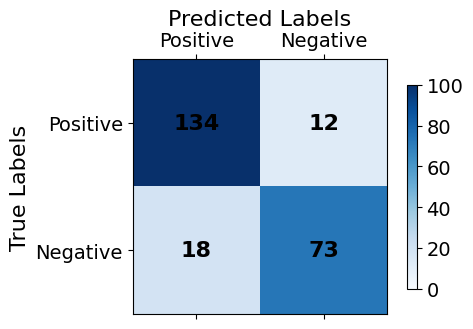


Selected features and their coefficient from the logistic regressor:

Sitzung.count: 2.1711980830988784
case:author_first_activity_landesregierung: 0.9788960762869107
2. Lesung.count: 0.7385456562958445

Intercept: [1.19252998]


In [60]:

x_train_featureSelection, x_test_featureSelection, y_train_featureSelection, y_test_featureSelection = train_test_split(X_new, target, test_size=0.33, random_state=42)
pipe_after_feature_selection = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, fit_intercept=True, random_state=42))
pipe_after_feature_selection.fit(x_train_featureSelection, y_train_featureSelection)
pipe_after_feature_selection.score(x_test_featureSelection, y_test_featureSelection)
print("pipe_after_feature_selection score:", pipe_after_feature_selection.score(x_test_featureSelection, y_test_featureSelection))
y_pred_featureSelection = pipe_after_feature_selection.predict(x_test_featureSelection)
createConfusionMatrix(y_test_featureSelection, y_pred_featureSelection, "logisticRegression_featureSelection" + bundesland + ".png")

# Access the final estimator
regressor = pipe_after_feature_selection.steps[-1][1]

# get names of features that were selected
print("\nSelected features and their coefficient from the logistic regressor:\n")

# Get the coefficients and their corresponding feature names
coefficients = regressor.coef_[0]
features = data.columns[model.get_support()]

# Combine them into a list of tuples
feature_coefficients = list(zip(features, coefficients))

# Sort the list by the absolute value of the coefficients in descending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Print the sorted features and their coefficients
for feature, coef in sorted_feature_coefficients:
    print(f"{feature}: {coef}")

print("\nIntercept:", regressor.intercept_)

